In [12]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [13]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT
from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer

# Select Model
model_choice = "pmh_model"
engine_config = MODEL_STRUCT.get(model_choice)

if engine_config is None:
    raise ValueError(f"Model {model_choice} not found.")

print(f"Loaded configuration for: {model_choice}")
print(engine_config)

Loaded configuration for: pmh_model
{'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies_a', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.05, 'gamma': 0.9}}}, 'agenda': ['perception_mod', 'hypo_transitions_mod', 'likelihood_mod', 'memory_mod']}


In [14]:
import importlib
import src.Bayesian_state.utils.state_grid_optimizer
import src.Bayesian_state.problems.model
import src.Bayesian_state.inference_engine.bayesian_engine
import src.Bayesian_state.problems.modules.memory

importlib.reload(src.Bayesian_state.inference_engine.bayesian_engine)
importlib.reload(src.Bayesian_state.problems.modules.memory)
importlib.reload(src.Bayesian_state.problems.model)
importlib.reload(src.Bayesian_state.utils.state_grid_optimizer)

from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer
from src.Bayesian_state.problems import StateModel

print("Modules reloaded.")

{'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 15.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies_a', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'cl

In [15]:
import os
import multiprocessing

cpu_count = os.cpu_count()
print(f"Total CPU cores available: {cpu_count}")

# Recommendation: Leave 1-2 cores free for system tasks
recommended_n_jobs = max(1, cpu_count - 2)
print(f"Recommended n_jobs: {recommended_n_jobs}")

Total CPU cores available: 16
Recommended n_jobs: 14


In [16]:
# Initialize Optimizer
optimizer = StateModelGridOptimizer(
    engine_config=engine_config,
    processed_data_dir=DATA_ROOT,
    n_jobs=12 # Adjust based on your CPU cores
)
print("Optimizer initialized.")

Optimizer initialized.


In [17]:
subject_id = 2

# Example Grid: Optimizing gamma (forgetting) and w0 (background noise)
# 都舍入到小数点后4位

# TODO：Adaptive Mesh Refinement (AMR) for more efficient search
param_grid = {
    "gamma": [0.1, 0.4, 0.7, 0.9, 0.95],
    "w0": [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.9],
    "beta": [2., 5., 10., 20., 30.]
}

print(f"Starting optimization for Subject {subject_id}...")
print(f"Parameter Grid: {param_grid}")

# Run Optimization
# n_repeats: Number of runs per grid point for coarse selection
# refit_repeats: Number of runs for the best parameter set for fine estimation
results = optimizer.optimize_subject(
    subject_id=subject_id,
    param_grid=param_grid,
    n_repeats=8,        
    refit_repeats=256,    
    keep_logs=False
)

print("Optimization complete.")

INFO:cat-learning:Optimizing subject 2: 175 combos * 8 repeats = 1400 tasks


Starting optimization for Subject 2...
Parameter Grid: {'gamma': [0.1, 0.4, 0.7, 0.9, 0.95], 'w0': [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.9], 'beta': [2.0, 5.0, 10.0, 20.0, 30.0]}


Sub 2 Grid Search: 100%|██████████| 1400/1400 [08:35<00:00,  2.71it/s]
INFO:cat-learning:Refitting best params for subject 2 with 256 repeats.
Sub 2 Refit: 100%|██████████| 256/256 [37:36<00:00,  8.82s/it]  


Optimization complete.


In [18]:
# Analyze Results
best_result = results['best']

print("="*40)
print(f"Optimization Results for Subject {subject_id}")
print("="*40)
print(f"Best Parameters: {best_result.params}")
print(f"Best Mean Error: {best_result.mean_error:.6f}")
print(f"Standard Error:  {best_result.std_error:.6f}")
print("-" * 40)

# Convert grid results to DataFrame for easier viewing
grid_data = []
for res in results['grid']:
    row = res.params.copy()
    row['mean_error'] = res.mean_error
    row['std_error'] = res.std_error
    grid_data.append(row)

df_results = pd.DataFrame(grid_data)
df_results = df_results.sort_values('mean_error')

print("\nTop 5 Parameter Combinations:")
print(df_results.head(5))

Optimization Results for Subject 2
Best Parameters: {'beta': 10.0, 'gamma': 0.4, 'w0': 0.01}
Best Mean Error: 0.105163
Standard Error:  0.009467
----------------------------------------

Top 5 Parameter Combinations:
    beta  gamma    w0  mean_error  std_error
37  10.0    0.4  0.01    0.105163   0.009467
7   10.0    0.1  0.02    0.107468   0.000835
2   10.0    0.1  0.01    0.107822   0.010630
42  10.0    0.4  0.02    0.111015   0.001076
77  10.0    0.7  0.02    0.116072   0.006735


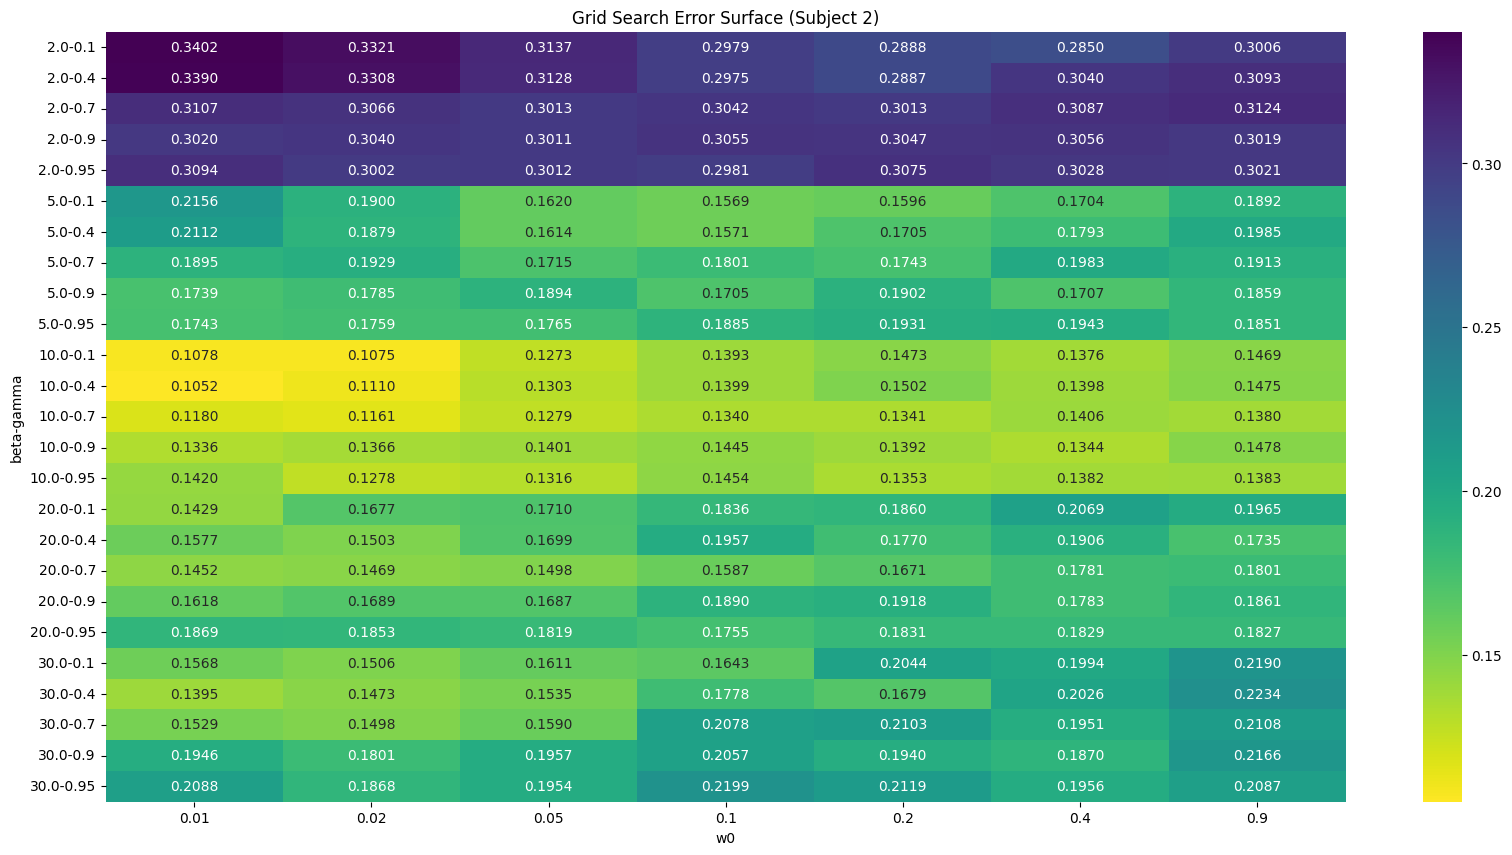

In [19]:
# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot for heatmap (assuming 2D grid: gamma vs w0)
if "gamma" in df_results.columns and "w0" in df_results.columns:
    pivot_table = df_results.pivot(index=["beta", "gamma"], columns="w0", values="mean_error")
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r")
    plt.title(f"Grid Search Error Surface (Subject {subject_id})")
    plt.show()


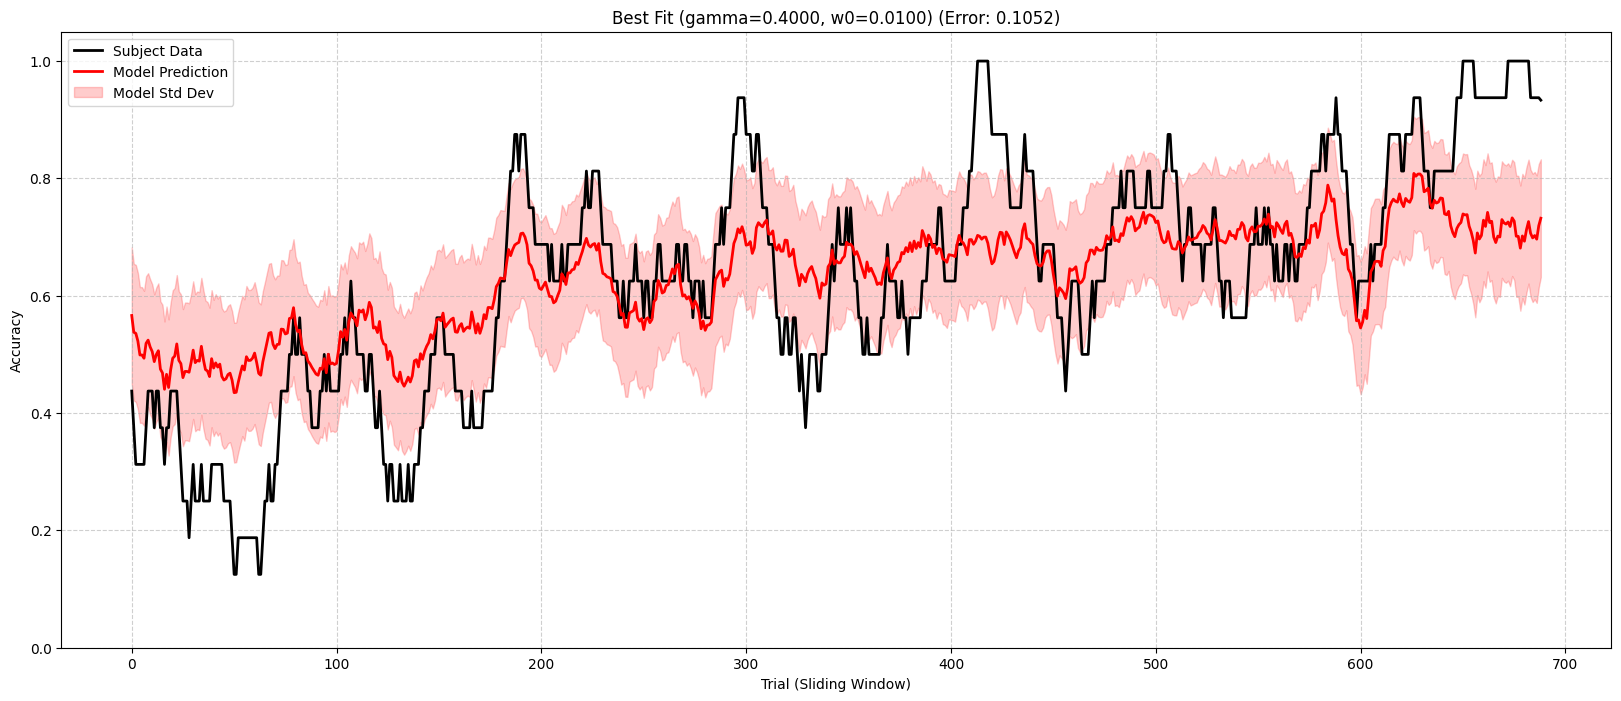

In [20]:

# Plot Best
plot_result = best_result
title_prefix = f"Best Fit (gamma={best_result.params.get('gamma'):.4f}, w0={best_result.params.get('w0'):.4f})"

# Plot Fit Curve
plt.figure(figsize=(20, 8))
metrics = plot_result.metrics
sliding_true = metrics["sliding_true_acc"]
sliding_pred = metrics["sliding_pred_acc"]
sliding_std = metrics["sliding_pred_acc_std"]
trials = np.arange(len(sliding_true))

plt.plot(trials, sliding_true, label="Subject Data", color="black", linewidth=2)
plt.plot(trials, sliding_pred, label="Model Prediction", color="red", linewidth=2)

# Add confidence interval if available
if sliding_std is not None and not np.all(np.isnan(sliding_std)):
    plt.fill_between(
        trials, 
        sliding_pred - sliding_std, 
        sliding_pred + sliding_std, 
        color="red", 
        alpha=0.2,
        label="Model Std Dev"
    )

plt.xlabel("Trial (Sliding Window)")
plt.ylabel("Accuracy")
plt.title(f"{title_prefix} (Error: {plot_result.mean_error:.4f})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 1.05)
plt.show()

In [21]:
# Re-run best params once to capture posterior/prior logs and strategy_counts_log for plotting
from copy import deepcopy
import numpy as np
import pandas as pd

# Helper: inject params into config (gamma, w0, beta)
def _inject_params(config: dict, params: dict[str, float]) -> dict:
    cfg = deepcopy(config)
    shortcuts = {
        "gamma": "modules.memory_mod.kwargs.gamma",
        "w0": "modules.memory_mod.kwargs.w0",
        "beta": "modules.likelihood_mod.kwargs.beta",
    }
    def set_by_path(root: dict, path: str, value: float):
        parts = path.split(".")
        curr = root
        for part in parts[:-1]:
            curr = curr.setdefault(part, {})
        curr[parts[-1]] = value
    for k, v in params.items():
        path = shortcuts.get(k, k)
        set_by_path(cfg, path, v)
    return cfg

best_params = results["best"].params
refit_cfg = _inject_params(engine_config, best_params)

# Load subject data (reuse optimizer data)
subject_frame = optimizer._get_subject_frame(subject_id=subject_id, stop_at=1.0)
stimulus = subject_frame[["feature1", "feature2", "feature3", "feature4"]].to_numpy(float)
choices = subject_frame["choice"].to_numpy(int)
feedback = subject_frame["feedback"].to_numpy(float)

# Build trial sequence
trial_sequence = [[stimulus[i], int(choices[i]), float(feedback[i])] for i in range(len(feedback))]

# Build model and run
from src.Bayesian_state.problems import StateModel
model_plot = StateModel(
    refit_cfg,
    condition=int(subject_frame["condition"].iloc[0]),
    subject_id=subject_id,
    processed_data_dir=DATA_ROOT,
)
model_plot.precompute_distances(stimulus)
posterior_log, prior_log = model_plot.fit_step_by_step(trial_sequence)

# Collect strategy counts if available
hypo_mod = None
strategy_counts_log = []
if hasattr(model_plot.engine, "modules"):
    hypo_mod = model_plot.engine.modules.get("hypo_transitions_mod")
    if hypo_mod is not None and hasattr(hypo_mod, "strategy_counts_log"):
        strategy_counts_log = hypo_mod.strategy_counts_log

has_strategy_counts = bool(strategy_counts_log)
strategy_counts = {}
active_total = []
trial_axis = np.arange(len(posterior_log))
if has_strategy_counts:
    strategy_names = sorted({k for step in strategy_counts_log for k in step.keys() if k != "active_total"})
    strategy_counts = {name: [] for name in strategy_names}
    for step in strategy_counts_log:
        active_total.append(step.get("active_total", 0))
        for name in strategy_names:
            strategy_counts[name].append(step.get(name, 0))
    trial_axis = np.arange(len(strategy_counts_log))


INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.
INFO:cat-learning:  - Module 'hypo_transitions_mod' registered as 'self.hypo_transitions_mod'.
INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\modules\memory.py:223: RuntimeWarning: divide by zero encountered in log
  return np.log(clipped)
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Loading similarity matrix from disk: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\cache\similarity_matrix_d4_c4.npy
{'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': [0.004427081236447525, 0.022255364028172773, -0.0022781527627494173, 0.013763640023340516], 'std': [0.048823344105895415, 0.05833964381501184, 0.0291372907468654, 0.05925183370141004], 'subject_id': 2}}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies_a', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.01, 'gamma': 0.4}}}
name: perception_mod mod_kwargs: {'mean': [0.004427081236447525, 0.02225536402817

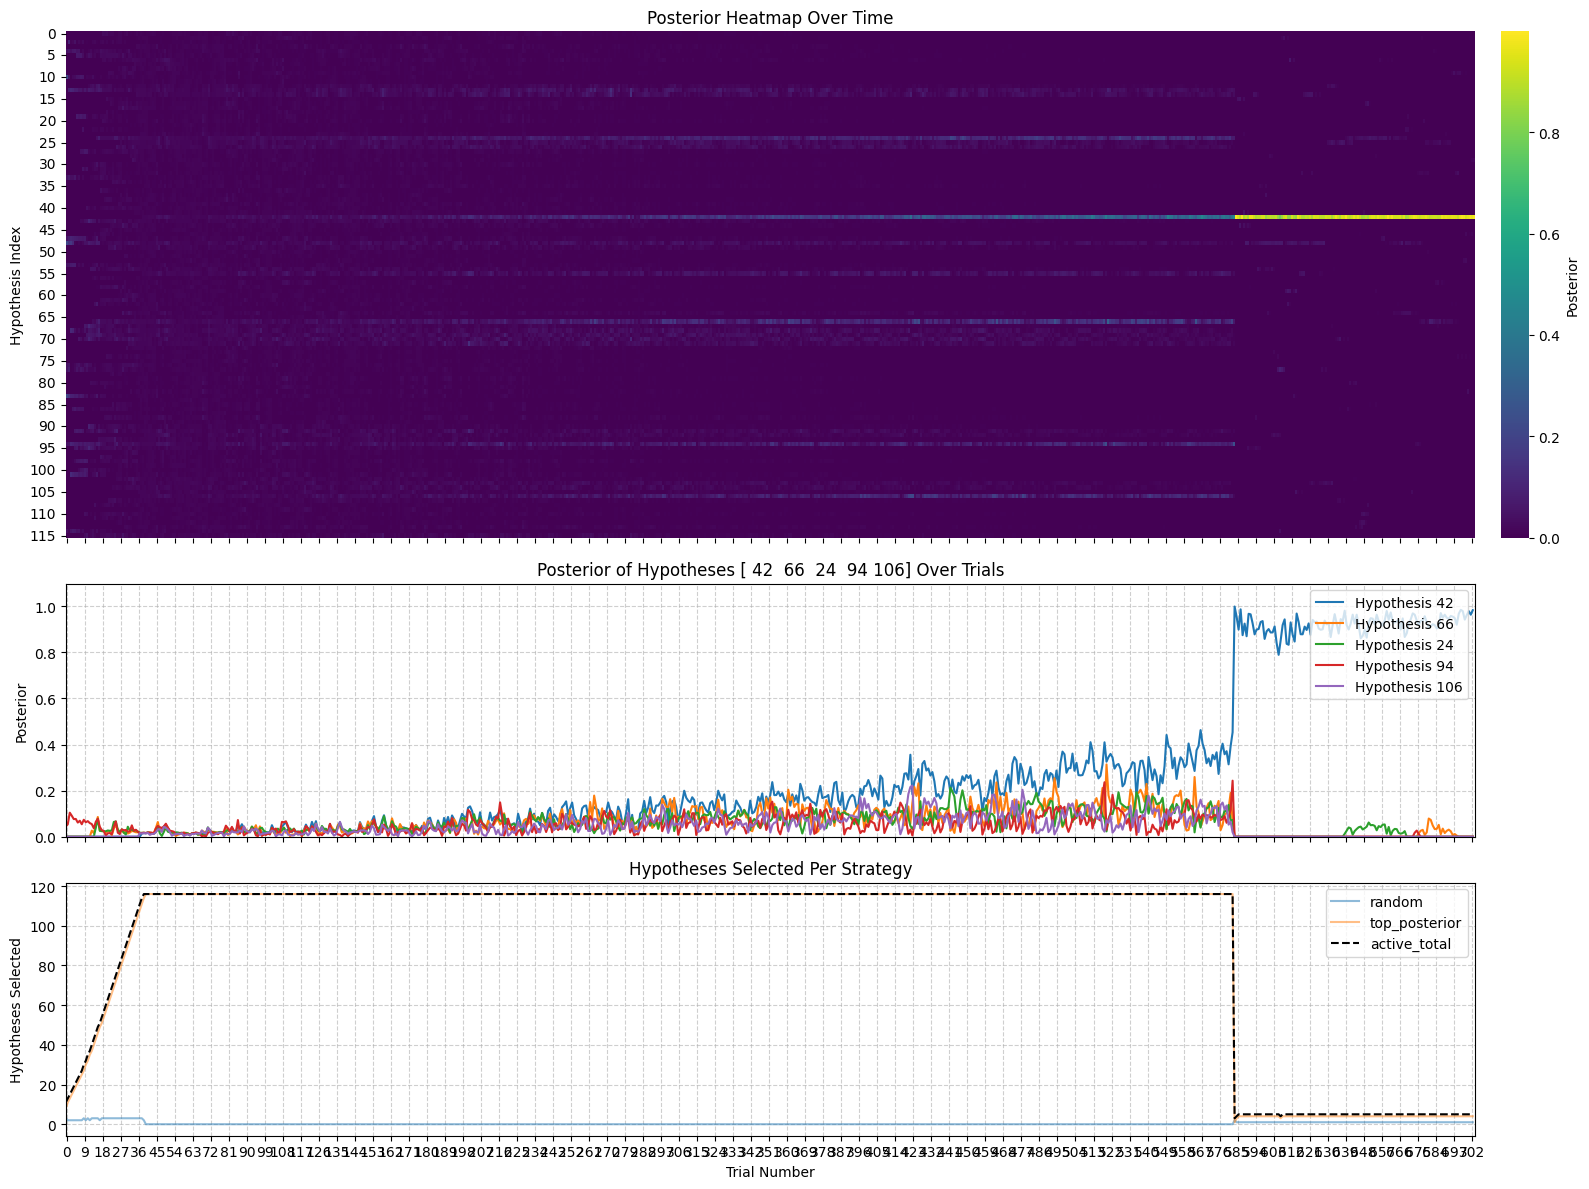

In [22]:
# Plot posterior + strategy counts (mirroring Bayesian_state.ipynb style)
import matplotlib.pyplot as plt
import seaborn as sns

posterior_array = np.array(posterior_log).T
n_steps = posterior_array.shape[1]
trials = np.arange(n_steps)

# Top 5 by total posterior mass
post_sum_hypo = np.sum(posterior_log, axis=0)
top5_indices = np.argsort(post_sum_hypo)[-5:][::-1]
active_hypos_num_list = [np.argwhere(posterior_log[i]).shape[0] for i in range(len(posterior_log))]

if has_strategy_counts:
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex='col',
                             gridspec_kw={'height_ratios': [2, 1, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = axes[2, 0]
    axes[1, 1].axis('off')
    axes[2, 1].axis('off')
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex='col',
                             gridspec_kw={'height_ratios': [2, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = None
    axes[1, 1].axis('off')

# Heatmap
sns.heatmap(posterior_array, cmap="viridis", ax=ax_heatmap, cbar_ax=ax_cbar, cbar_kws={'label': 'Posterior'})
ax_heatmap.set_ylabel("Hypothesis Index")
ax_heatmap.set_title("Posterior Heatmap Over Time")

# Lines for top hypotheses
max_post_overall = 0
for hypo_index in top5_indices:
    hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
    max_post = max(hypo_posterior_over_time)
    max_post_overall = max(max_post_overall, max_post)
    ax_line.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
ax_line.set_ylabel('Posterior')
ax_line.set_ylim(0, max_post_overall * 1.1)
ax_line.grid(True, linestyle='--', alpha=0.6)
ax_line.legend(loc='upper right')
ax_line.set_title(f'Posterior of Hypotheses {top5_indices} Over Trials')

# Strategy counts
if has_strategy_counts and ax_count is not None:
    min_len = min(len(trial_axis), n_steps)
    for name, counts in strategy_counts.items():
        ax_count.plot(trial_axis[:min_len], counts[:min_len], label=f'{name}', alpha=0.5)
    ax_count.plot(trial_axis[:min_len], active_total[:min_len], color='black', linestyle='--', label='active_total')
    ax_count.set_ylabel('Hypotheses Selected')
    ax_count.set_xlabel('Trial Number')
    ax_count.grid(True, linestyle='--', alpha=0.6)
    ax_count.legend(loc='upper right')
    ax_count.set_title('Hypotheses Selected Per Strategy')

plt.tight_layout()
plt.show()
